In [81]:
import sys
sys.path.insert(0, '/home/alapena/GitHub/graph2mat4abn')
import os
os.chdir('/home/ICN2/alapena/GitHub/graph2mat4abn') # Change to the root directory of the project

from graph2mat4abn.tools.import_utils import load_config, get_object_from_module
from graph2mat4abn.tools.tools import get_basis_from_structures_paths, get_kwargs, load_model
from graph2mat4abn.tools.scripts_utils import get_model_dataset, init_mace_g2m_model
from graph2mat4abn.tools.script_plots import update_loss_plots, plot_grad_norms
from pathlib import Path
from e3nn import o3
from mace.modules import MACE, RealAgnosticResidualInteractionBlock
from graph2mat.models import MatrixMACE
from graph2mat.bindings.e3nn import E3nnGraph2Mat
import torch
import warnings
from graph2mat import BasisTableWithEdges

warnings.filterwarnings("ignore", message="The TorchScript type system doesn't support")
warnings.filterwarnings("ignore", message=".*is not a known matrix type key.*")

from joblib import dump, load
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import sisl

In [82]:
model_dir = Path("results/h_crystalls_8")
directory = Path("results_dos/h_crystalls_8_val") # To take the bands and dos results _fullEnergyRange
filename = "val_best_model.tar"
split = "val"
path = Path("dataset/SHARE_OUTPUTS_8_ATOMS/7b57-1410-4da3-8535-5183ac1f2f61")

n_atoms = path.parts[-2].split("_")[2]
structure = path.parts[-1]

In [83]:
config = load_config(model_dir / "config.yaml")

# Basis generation (needed to initialize the model)
train_paths, val_paths = get_model_dataset(model_dir, verbose=False)
paths = train_paths + val_paths
basis = get_basis_from_structures_paths(paths, verbose=True, num_unique_z=config["dataset"].get("num_unique_z", None))
table = BasisTableWithEdges(basis)

print("Initializing model...")
model, optimizer, lr_scheduler, loss_fn = init_mace_g2m_model(config, table)

# Load the model
model_path = model_dir / filename
model, checkpoint, optimizer, lr_scheduler = load_model(model, optimizer, model_path, lr_scheduler=None, initial_lr=None, device='cpu')
history = checkpoint["history"]
print(f"Loaded model in epoch {checkpoint["epoch"]} with training loss {checkpoint["train_loss"]} and validation loss {checkpoint["val_loss"]}.")

Basis computation.
Number of structures to look on: 582
Looking for unique atoms in each structure...


1it [00:00, 70.28it/s]

Found enough basis points. Breaking the search...
Found enough basis points. Breaking the search...
Found the following atomic numbers: [5, 7]
Corresponding path indices: [0, 0]
Basis with 2 elements built!

Basis for atom 0.
	Atom type: 5
	Basis: ((2, 0, 1), (2, 1, -1), (1, 2, 1))
	Basis convention: siesta_spherical
	R: [3.02420918 2.02341372 3.73961942 3.73961942 3.73961942 2.51253945
 2.51253945 2.51253945 3.73961942 3.73961942 3.73961942 3.73961942
 3.73961942]

Basis for atom 1.
	Atom type: 7
	Basis: ((2, 0, 1), (2, 1, -1), (1, 2, 1))
	Basis convention: siesta_spherical
	R: [2.25704422 1.4271749  2.78012609 2.78012609 2.78012609 1.75309697
 1.75309697 1.75309697 2.78012609 2.78012609 2.78012609 2.78012609
 2.78012609]
Initializing model...



/home/ICN2/alapena/miniconda3/envs/graph2mat_upt/lib/python3.12/site-packages/mace/modules/blocks.py:187: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Using Optimizer Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
LR Scheduler:  ReduceLROnPlateau
Arguments:  None
Keyword arguments:  {'cooldown': 0, 'eps': 0.0, 'factor': 0.9, 'min_lr': 1e-09, 'mode': 'min', 'patience': 100}
Using Loss function <class 'graph2mat.core.data.metrics.block_type_mse'>
Loaded model in epoch 3432 with training loss 10257.6044921875 and validation loss 14554.40234375.


In [84]:
# Loss fn

import math
import torch

def block_type_mse_threshold_custom(
    nodes_pred,
    nodes_ref,
    edges_pred,
    edges_ref,
    threshold=1e-4,
    log_verbose=False,
    **kwargs,
):
    def _isnan(values):
        """NaN checking compatible with both torch and numpy"""
        return values != values

    def get_predictions_error(
        nodes_pred, nodes_ref, edges_pred, edges_ref, remove_nan=True
    ):
        """Returns errors for both nodes and edges, removing NaN values."""
        node_error = nodes_pred - nodes_ref

        if remove_nan:
            notnan = ~_isnan(edges_ref)
            edge_error = edges_ref[notnan] - edges_pred[notnan]
        else:
            edge_error = edges_ref - edges_pred

        return node_error, edge_error

    def _safe_mean(x):
        """mean that returns 0 on empty tensors."""
        return x.mean() if x.numel() > 0 else x.new_tensor(0.0)

    def _percentile_linear(x: torch.Tensor, q: float) -> torch.Tensor:
        """
        Quantile via kthvalue with linear interpolation (matches torch.quantile default).
        Works on 1D input. Uses only torch ops for gradient tracking through values.
        """
        x = x.reshape(-1)
        n = x.numel()
        if n == 0:
            return x.new_tensor(float("nan"))
        if n == 1:
            return x[0]

        # rank in [0, n-1]
        r = (n - 1) * float(q)
        k_low = int(math.floor(r)) + 1   # kthvalue is 1-indexed
        k_high = int(math.ceil(r)) + 1

        v_low, _ = torch.kthvalue(x, k_low)
        if k_high == k_low:
            return v_low

        v_high, _ = torch.kthvalue(x, k_high)
        w = r - (k_low - 1)  # fractional part as Python float
        w_t = x.new_tensor(w)
        return v_low + (v_high - v_low) * w_t

    node_error, edge_error = get_predictions_error(
        nodes_pred, nodes_ref, edges_pred, edges_ref
    )

    n_node_els = node_error.shape[0]
    n_edge_els = edge_error.shape[0]

    abs_node_error = abs(node_error)
    abs_edge_error = abs(edge_error)

    node_error_above_thresh = node_error[abs_node_error > threshold]
    edge_error_above_thresh = edge_error[abs_edge_error > threshold]

    # Base losses (safe on empties)
    node_loss = _safe_mean(node_error_above_thresh**2)
    edge_loss = _safe_mean(edge_error_above_thresh**2)

    # 75th percentiles using manual quantile
    if node_error_above_thresh.numel() > 0:
        abs_node_err_above = node_error_above_thresh.abs()
        percentile_75 = _percentile_linear(abs_node_err_above, 0.75)
        hard_mask = abs_node_err_above > percentile_75
        hard_errors = node_error_above_thresh[hard_mask]
        if hard_errors.numel() > 0:
            node_loss = node_loss + _safe_mean(hard_errors**2)

    if edge_error_above_thresh.numel() > 0:
        abs_edge_err_above = edge_error_above_thresh.abs()
        edge_percentile_75 = _percentile_linear(abs_edge_err_above, 0.75)
        edge_hard_mask = abs_edge_err_above > edge_percentile_75
        edge_hard_errors = edge_error_above_thresh[edge_hard_mask]
        if edge_hard_errors.numel() > 0:
            edge_loss = edge_loss + _safe_mean(edge_hard_errors**2)

    # Stats (avoid NaNs on empties for the *_above_threshold_mean)
    stats = {
        "node_rmse": torch.sqrt(_safe_mean(node_error**2)),
        "edge_rmse": torch.sqrt(_safe_mean(edge_error**2)),
        "node_above_threshold_frac": (
            node_error_above_thresh.shape[0] / max(1, n_node_els)
        ),
        "edge_above_threshold_frac": (
            edge_error_above_thresh.shape[0] / max(1, n_edge_els)
        ),
        "node_above_threshold_mean": _safe_mean(
            abs_node_error[abs_node_error > threshold]
        ),
        "edge_above_threshold_mean": _safe_mean(
            abs_edge_error[abs_edge_error > threshold]
        ),
    }

    if log_verbose:
        stats.update(
            {
                "node_mean": abs_node_error.mean(),
                "edge_mean": abs_edge_error.mean(),
                "node_std": abs_node_error.std(),
                "edge_std": abs_edge_error.std(),
                "node_max": abs_node_error.max(),
                "edge_max": abs_edge_error.max(),
            }
        )

    return node_loss + edge_loss, stats

# loss_fn = block_type_mse_threshold_custom

In [85]:
# === Inference ===


from torch_geometric.data import DataLoader
from graph2mat4abn.tools.scripts_utils import generate_g2m_dataset_from_paths

dataset, processor = generate_g2m_dataset_from_paths(config, basis, table, [path], verbose=False)
dataloader = DataLoader(dataset, 1)
model.eval()

data = next(iter(dataloader))

mean_abs_point_nonzero = 1.2254
mean_abs_edge_nonzero = 0.1527

with torch.no_grad():
    model_predictions = model(data=data)

    # loss, stats = loss_fn(
    #     nodes_pred=model_predictions["node_labels"],
    #     nodes_ref=data.point_labels / (mean_abs_point_nonzero + 1e-10), # Normalize
    #     edges_pred=model_predictions["edge_labels"],
    #     edges_ref=data.edge_labels / (mean_abs_edge_nonzero + 1e-10), # Normalize
    #     threshold=0.0001 # 10 meV
    # )
    # print("Loss evaluation:", loss.item())
    # print("Last train loss:", history["train_loss"][-1])

    h_pred = processor.matrix_from_data(data, predictions={"node_labels": model_predictions["node_labels"], "edge_labels": model_predictions["edge_labels"]})[0]
    h_true = processor.matrix_from_data(data)[0]

1it [00:00, 26.81it/s]

Keeping all the dataset in memory.



/home/ICN2/alapena/miniconda3/envs/graph2mat_upt/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning:

'data.DataLoader' is deprecated, use 'loader.DataLoader' instead



In [86]:
file = sisl.get_sile(path / "aiida.fdf")
fig = file.plot.geometry(axes="xyz")
# filepath = savedir_struct / f"{n_atoms}atm_{structure}.png"
# fig.write_image(str(filepath))
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    showlegend=False,
)
fig.show()

filename = f"{split}_{n_atoms}atm_{structure}_structure.png"
dir = Path("exports") / model_dir.parts[-1] 
filepath = dir/ filename
dir.mkdir(exist_ok=True, parents=True)
fig.write_image(filepath)

/tmp/ipykernel_1379546/2828579389.py:18: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_1379546/2828579389.py:18: RuntimeWarning:

invalid value encountered in divide



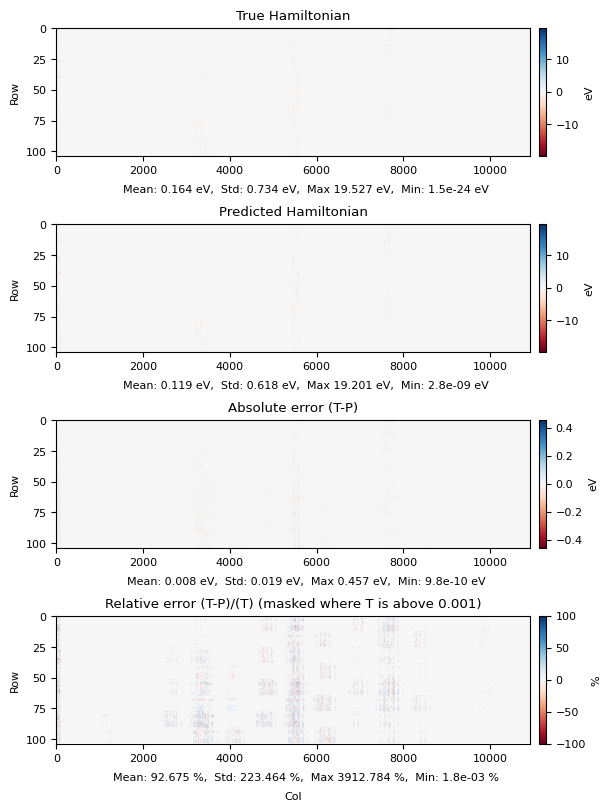

In [87]:
# Plot hamiltonian

def plot_hamiltonian_matplotlib(true_matrix, predicted_matrix, matrix_label=None, figure_title=None, predicted_matrix_text=None, filepath=None, force_max_colorbar_abs_error=None, only_first_uc=False):
    """Matplotlib visualization of error matrices."""

    if only_first_uc:
        n_orbs = true_matrix.shape[0]
        true_matrix = true_matrix[:, :n_orbs]
        predicted_matrix = predicted_matrix[:, :n_orbs]
        figsize=(4, 8)
    else:
        figsize=(6, 8)

    # Error matrices
    absolute_error_matrix = true_matrix - predicted_matrix
    threshold = 0.001
    mask = true_matrix >= threshold
    relative_error_matrix = np.where(mask, absolute_error_matrix / (true_matrix) * 100, 0)

    # Colorbar limits
    vmin = np.min([np.min(true_matrix), np.min(predicted_matrix)])
    vmax = np.max([np.max(true_matrix), np.max(predicted_matrix)])
    lim_data = max(np.abs(vmin), np.abs(vmax))

    if force_max_colorbar_abs_error is None:
        lim_abs = np.max(np.abs(absolute_error_matrix))
    else:
        lim_abs = force_max_colorbar_abs_error

    lim_rel = 100.0  # %

    cbar_limits = [lim_data, lim_data, lim_abs, lim_rel]

    # Titles
    if matrix_label is None:
        matrix_label = ''
    titles = [
        "True " + matrix_label,
        "Predicted " + matrix_label,
        "Absolute error (T-P)",
        f"Relative error (T-P)/(T) (masked where T is above {threshold})"
    ]
    cbar_titles = ["eV", "eV", "eV", "%"]

    # Matrices to plot
    matrices = [true_matrix, predicted_matrix, absolute_error_matrix, relative_error_matrix]

    fig, axes = plt.subplots(4, 1, figsize=figsize, constrained_layout=True, gridspec_kw={'hspace': 0.15})
    # fig.suptitle(figure_title if figure_title else "Matrix Comparison and Errors", fontsize=16)

    for i, (matrix, ax) in enumerate(zip(matrices, axes)):
        im = ax.imshow(matrix, cmap='RdBu', vmin=-cbar_limits[i], vmax=cbar_limits[i])
        ax.set_title(titles[i])
        ax.set_ylabel("Row")
        cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.045, pad=0.02)
        cbar.set_label(cbar_titles[i])
        if i==3:
            ax.set_xlabel("Col", labelpad=20)
        ax.set_aspect('auto')
        

    y_offset = 0.035
    addition = 0.245
    # True matrix stats (exclude zeros for stats)
    matrix_nnz = np.abs(true_matrix)[true_matrix != 0]
    if matrix_nnz.size > 0:
        mean = np.mean(matrix_nnz)
        std = np.std(matrix_nnz)
    else:
        mean = std = 0.0
    vmax = np.max(matrix_nnz)
    vmin = np.min(matrix_nnz)
    max_abs= np.max(np.abs([vmax, vmin]))
    fig.text(
        0.5, y_offset + 3*addition,
        fr"Mean: {mean:.3f} eV,  Std: {std:.3f} eV,  Max {vmax:.3f} eV,  Min: {vmin:.1e} eV",
        ha='center', va='center', fontsize=8,
    )

    # Predicted stats
    matrix_nnz = np.abs(predicted_matrix)[predicted_matrix != 0]
    if matrix_nnz.size > 0:
        mean = np.mean(matrix_nnz)
        std = np.std(matrix_nnz)
    else:
        mean = std = 0.0
    vmax = np.max(matrix_nnz)
    vmin = np.min(matrix_nnz)
    max_abs= np.max(np.abs([vmax, vmin]))
    fig.text(
        0.5, y_offset + 2*addition,
        fr"Mean: {mean:.3f} eV,  Std: {std:.3f} eV,  Max {vmax:.3f} eV,  Min: {vmin:.1e} eV",
        ha='center', va='center', fontsize=8,
    )

    # Absolute error stats (exclude zeros for stats)
    matrix_nnz = np.abs(absolute_error_matrix)[absolute_error_matrix != 0]
    if matrix_nnz.size > 0:
        mean = np.mean(matrix_nnz)
        std = np.std(matrix_nnz)
    else:
        mean = std = 0.0
    vmax = np.max(matrix_nnz)
    vmin = np.min(matrix_nnz)
    max_abs= np.max(np.abs([vmax, vmin]))
    fig.text(
        0.5, y_offset + 1*addition,
        fr"Mean: {mean:.3f} eV,  Std: {std:.3f} eV,  Max {vmax:.3f} eV,  Min: {vmin:.1e} eV",
        ha='center', va='center', fontsize=8,
    )

    # Relative error stats (exclude zeros for stats)
    matrix_nnz = np.abs(relative_error_matrix)[relative_error_matrix != 0]
    if matrix_nnz.size > 0:
        mean = np.mean(matrix_nnz)
        std = np.std(matrix_nnz)
    else:
        mean = std = 0.0
    vmax = np.max(matrix_nnz)
    vmin = np.min(matrix_nnz)
    max_abs= np.max(np.abs([vmax, vmin]))
    fig.text(
        0.5, y_offset + 0*addition,
        fr"Mean: {mean:.3f} %,  Std: {std:.3f} %,  Max {vmax:.3f} %,  Min: {vmin:.1e} %",
        ha='center', va='center', fontsize=8,
    )

    # axes[-1].set_xlabel(" ")

    # Output
    if filepath:
        plt.savefig(filepath, dpi=150, bbox_inches='tight')
        plt.close(fig)
    return fig

fig = plot_hamiltonian_matplotlib(true_matrix=h_true.todense(), predicted_matrix=h_pred.todense(), matrix_label="Hamiltonian")
fig.show()

filename = f"{split}_{n_atoms}atm_{structure}_ham.png"
filepath = Path("exports") / model_dir.parts[-1] / filename
fig.savefig(str(filepath), dpi=150, bbox_inches="tight")

/tmp/ipykernel_1379546/2828579389.py:18: RuntimeWarning:

divide by zero encountered in divide



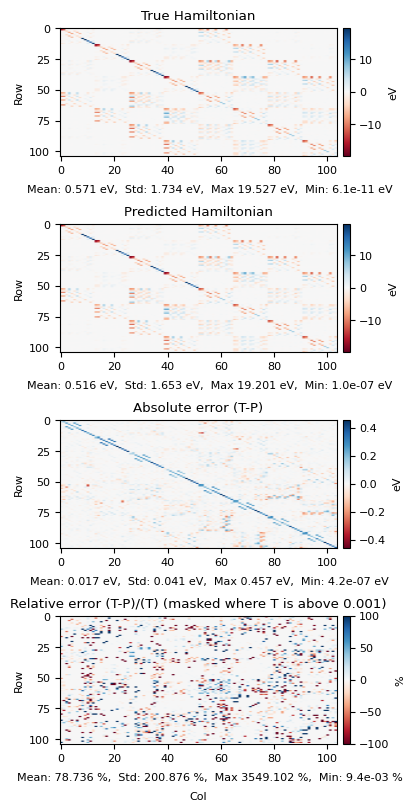

In [88]:
# Plot only the zero shift

fig = plot_hamiltonian_matplotlib(true_matrix=h_true.todense(), predicted_matrix=h_pred.todense(), matrix_label="Hamiltonian", only_first_uc=True)
fig.show()

filename = f"{split}_{n_atoms}atm_{structure}_ham_little.png"
filepath = Path("exports") / model_dir.parts[-1] / filename
fig.savefig(str(filepath), dpi=150, bbox_inches="tight")

# Bands, Fermi Energy, DOS

In [89]:
# Fermi from Thomas:

import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt


#Find the "Fermi Energy" from the DOS
def FindFermi2(energies, dos, N_orbitals, N_electrons, mode='linear', ShowPlot=False):
    """
    Estimates from the DOS the lowest energy E_Fermi such that the total number of states below E_Fermi is equal to the number of filled states. Expects a spinless calculation.
    INPUTS:
    energies, np.array of floats: the energies for which the DOS was computed.
    dos, np.array of floats: the corresponding dos values.
    N_orbitals: the total number of orbitals in the system (e.g. 12 per atom in a typical SIESTA calculation)
    N_electrons: the total number of electrons in the system (so in a typical BN calculation without spin, 3 per B atom and 5 per N atom)
    mode, string: see code. One would expect linear is to be better usually.
    showPlot, bool: if True, displays a plot showing graphically the determination of E_Fermi.
    OUTPUTS:
    E_Fermi: estimate of the lowest energy such that the total number of states below that energy is equal to the number of filled states.
    """

    cross_val=N_electrons/2  #number of filled SPINLESS states.

    cum_int=integrate.cumulative_trapezoid(dos, energies, initial=0)  #cumulative integral providing (possibly up to normalization) the number of filled states up to a given energy
    cum_int=N_orbitals*cum_int/cum_int[-1]  #enforce normalisation (typically very close to 1 without it, but if cum_int(E) is flat near E_f, a small normalization error can yield very large E_fermi errors)
    ind_Fermi=np.argwhere(cum_int>cross_val)[0][0]  #the first index which passes the Fermi level

    if mode=='discrete':
        E_Fermi=energies[ind_Fermi]  #we just return that value. A priori limited to energy mesh precision.

    if mode=='linear':
        x1=energies[ind_Fermi-1]  #the first energy below
        y1=cum_int[ind_Fermi-1]

        x2=energies[ind_Fermi]    #the first one after
        y2=cum_int[ind_Fermi]

        #we now linearly interpolate the DOS between these two points to get a better estimator for E_fermi
        E_Fermi=(cross_val-y1)*(x2-x1)/(y2-y1)+x1

    if ShowPlot:
        #plt.scatter(energies, cum_int)
        plt.plot(energies, cum_int, label=r'$\int_{-\infty}^E DOS(E^\prime)dE^\prime$')
        plt.axhline(cross_val, ls='dotted', color='red', label=r'$N_{electrons}/2$')
        plt.axvline(E_Fermi, label=rf'$E_F$ estimate: {E_Fermi:.3f}', color='black', ls='dashed')
        plt.legend()
        plt.xlabel(r'Energy $E$')
        plt.ylabel('(Cumulative) number of (spinless) states')
        plt.show()


    return E_Fermi
    

Data extracted from results_dos/h_crystalls_8_val/val_8atm_7b57-1410-4da3-8535-5183ac1f2f61_dos_mesh30_true.npz
Fermi_thomas: 11.563487055421733
Fermi_siesta: -3.347358


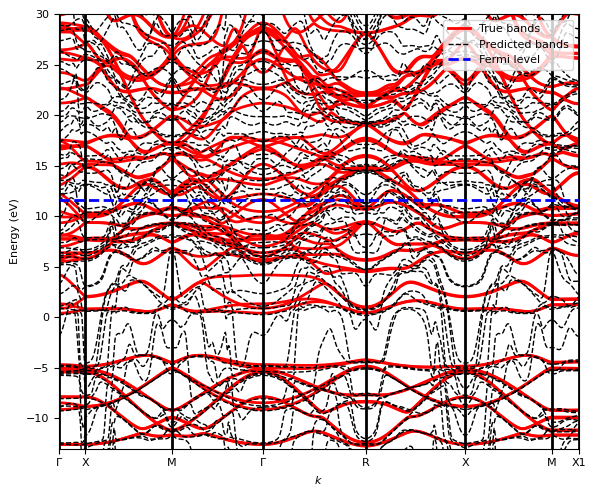

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import re

def read_fermi_level(path: str) -> float:
    """
    Return the last reported Fermi level (in eV) from a SIESTA aiida.out file.
    """
    pat = re.compile(r'Fermi\s*=\s*([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)')
    fermi = None
    with open(path, encoding="utf-8", errors="ignore") as fh:
        for line in fh:
            m = pat.search(line)
            if m:
                fermi = float(m.group(1))
    if fermi is None:
        raise ValueError("Fermi level not found in file.")
    return fermi

def plot_bands_matplotlib(k_len, bands, k_idx, k_label,
                          predicted_bands=None, filepath=None,
                          ylim=None, fermi_lvl=None, legend_loc=None):
    k_len = np.asarray(k_len)
    bands = np.asarray(bands)
    assert bands.ndim == 2, "bands must be (n_kpoints, n_bands)"

    fig, ax = plt.subplots(figsize=(6, 5), facecolor="white")
    ax.set_facecolor("white")

    # True bands: label only on the first column
    ax.plot(k_len, bands[:, 0], color="red", lw=2, label="True bands")
    ax.plot(k_len, bands[:, 1:], color="red", lw=2)  # no label

    # Predicted bands
    if predicted_bands is not None:
        predicted_bands = np.asarray(predicted_bands)
        assert predicted_bands.shape == bands.shape
        ax.plot(k_len, predicted_bands[:, 0], color="black", lw=1, ls="--", label="Predicted bands")
        ax.plot(k_len, predicted_bands[:, 1:], color="black", lw=1, ls="--")  # no label

    # Decide vertical line span
    if ylim is not None:
        vmin, vmax = ylim
    else:
        vmin = np.nanmin(bands if predicted_bands is None else np.dstack((bands, predicted_bands)))
        vmax = np.nanmax(bands if predicted_bands is None else np.dstack((bands, predicted_bands)))

    # Vertical separators
    ax.vlines(k_len[np.asarray(k_idx, int)], vmin, vmax, colors="black", lw=2)

    # Optional Fermi level
    if fermi_lvl is not None:
        ax.axhline(fermi_lvl, color="blue", ls="--", lw=2, label="Fermi level")

    # Axes & ticks
    ax.set_xlabel(r"$k$")
    ax.set_ylabel("Energy (eV)")
    ax.set_xlim(k_len.min(), k_len.max())
    ax.set_xticks(k_len[np.asarray(k_idx, int)])
    ax.set_xticklabels(k_label)
    if ylim is not None:
        ax.set_ylim(ylim)

    # Styling
    ax.tick_params(direction="out")
    for s in ax.spines.values():
        s.set_color("black")

    if legend_loc is None:
        legend_loc = "best"
    ax.legend(loc=legend_loc)
    fig.tight_layout()

    if filepath:
        fig.savefig(str(filepath), dpi=150, bbox_inches="tight")
    else:
        plt.show()

    return fig, ax

struct = f"{n_atoms}atm_" + structure
directory_bands = directory / "bands"

# Bands

# True
filename = struct + "_bands_true.npz"
filename = directory_bands / filename
loaded_file = np.load(filename)

k_idx = loaded_file["k_idx"]
k_label = loaded_file["k_label"]
energy = loaded_file["k_len"]
bands_true = loaded_file["bands"]

# Pred
filename = struct + "_bands_pred.npz"
filename = directory_bands / filename
loaded_file = np.load(filename)

bands_pred = loaded_file["bands"]

k_len_plot = np.repeat(energy[:,None], bands_true.shape[0], axis=1)
fermi_lvl=read_fermi_level(path / "aiida.out")


#DOS
# True
filename = split + "_" + struct + "_dos_mesh30_true.npz"
filename = directory / filename
loaded_file = np.load(filename)
print("Data extracted from", filename)

energies = loaded_file["energies"]
dos_true = loaded_file["dos"]

# Pred
# filename = struct + "_dos_mesh30_pred.npz"
# filename = directory / filename
# # loaded_file = np.load(filename)

energies_pred = loaded_file["energies"]
dos_pred = loaded_file["dos"]

#FERMI
fermi_lvl_thomas = FindFermi2(energies, dos_true, 13, 8,ShowPlot=False)
print("Fermi_thomas:", fermi_lvl_thomas)
fermi_lvl=read_fermi_level(path / "aiida.out")
print("Fermi_siesta:", fermi_lvl)



# fig_bands = plot_bands(k_len, bands, k_idx, k_label, predicted_bands=None, filepath=None)
ylim=[-13, 30]
fig_bands, ax = plot_bands_matplotlib(energy, bands_true, k_idx, k_label, predicted_bands=bands_pred, filepath=None, ylim=ylim, fermi_lvl=fermi_lvl_thomas, legend_loc="upper right")

filename = f"{split}_{n_atoms}atm_{structure}_bands.png"
filepath = Path("exports") / model_dir.parts[-1] / filename
fig_bands.savefig(str(filepath), dpi=150, bbox_inches="tight")

Fermi_thomas: 11.563487055421733
Fermi level: -3.347358


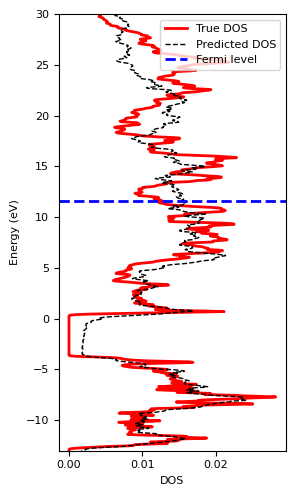

In [94]:
def plot_dos_matplotlib(
    energy, dos,
    predicted_energies=None, predicted_dos=None, filepath=None,
    ylim=None, fermi_lvl=None, legend_loc=None
):
    energy = np.asarray(energy)
    dos = np.asarray(dos)

    fig, ax = plt.subplots(figsize=(3, 5), facecolor="white")
    ax.set_facecolor("white")

    # True dos: label only on the first column
    ax.plot(dos, energy, color="red", lw=2, label="True DOS")

    # Predicted dos
    if predicted_dos is not None:
        predicted_dos = np.asarray(predicted_dos)
        ax.plot(predicted_dos, predicted_energies, color="black", lw=1, ls="--", label="Predicted DOS")

    # Optional Fermi level
    if fermi_lvl is not None:
        ax.axhline(fermi_lvl, color="blue", ls="--", lw=2, label="Fermi level")

    # Axes & ticks
    ax.set_xlabel(r"DOS")
    ax.set_ylabel("Energy (eV)")
    if ylim is not None:
        ax.set_ylim(ylim)

    # Styling
    ax.tick_params(direction="out")

    if legend_loc is None:
        legend_loc = "best"
    ax.legend(loc=legend_loc)
    fig.tight_layout()

    if filepath:
        fig.savefig(str(filepath), dpi=150, bbox_inches="tight")

    return fig, ax

# DOS

# True
filename = split + "_" + struct + "_dos_mesh30_true.npz"
filename = directory / filename
loaded_file = np.load(filename)

energies = loaded_file["energies"]
dos_true = loaded_file["dos"]

fermi_lvl_thomas = FindFermi2(energies, dos_true, 13, 8,ShowPlot=False)
print("Fermi_thomas:", fermi_lvl_thomas)

# Pred
filename = split + "_" + struct + "_dos_mesh30_pred.npz"
filename = directory / filename
loaded_file = np.load(filename)

energies_pred = loaded_file["energies"]
dos_pred = loaded_file["dos"]

fermi_lvl=read_fermi_level(path / "aiida.out")
print("Fermi level:", fermi_lvl)

# fig_bands = plot_dos_matplotlib(energies, dos_true, predicted_energies=None, predicted_dos=None, filepath=None, ylim=ylim, fermi_lvl=fermi_lvl, legend_loc="upper right")
fig_dos, ax = plot_dos_matplotlib(energies, dos_true, predicted_energies=energies_pred, predicted_dos=dos_pred, filepath=None, ylim=ylim, fermi_lvl=fermi_lvl_thomas, legend_loc="upper right")

filename = f"{split}_{n_atoms}atm_{structure}_dos.png"
filepath = Path("exports") / model_dir.parts[-1] / filename
fig_dos.savefig(str(filepath), dpi=150, bbox_inches="tight")